# 4.4 - Probabilistic sampling revisted

*Andrew Valentine & Malcolm Sambridge - Research School of Earth Sciences, The Australian National University - Last updated Sept. 2019*

'Receiver functions' are a class of seismic data used to study discontinuities (layering) in the Earth's crust. At each discontinuity, P-to-S conversions occur, introducing complexity in the waveform. By deconvolving horizontal- and vertical-channel waveforms from earthquakes at teleseismic distances, we can isolate information about these conversions, and hence learn about the crustal structure. This deconvolved signal is the receiver function, and has a highly non-linear dependence on the local crustal properties.

In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from inversionCourse import rf
from scipy import stats
from inversionCourse import plotcovellipse as pc
import seaborn as sns

The function `rf.rfcalc()` computes synthetic receiver functions (using routines developed by Takuo Shibutani). It is called as follows:
```python
t,rfunc = rf.rfcalc(model)
```
where `model` is a NumPy array of dimension `[nlayers,3]`. The values in `model[:,0]` give the depths of discontinuities in the model, while `model[:,1]` contains the S-wave speed above the interface. `model[:,2]` is the ratio of S-wave speed to P-wave speed. The maximum depth of discontinuity that can be considered is 60km.

For example, here is the Earth model.

In [23]:
model = np.array([[1,4.0,1.7],
                  [3.5,4.3,1.7],
                  [8.0,4.2,2.0],
                  [20, 6,1.7],
                  [45,6.2,1.7]])

Lets plot the Earth model

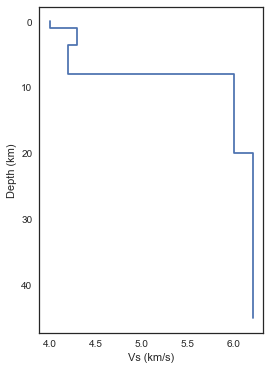

In [24]:
px = np.zeros([2*len(model),2])
py = np.zeros([2*len(model),2])
n=len(model)
px[0::2,0],px[1::2,0],px[1::2,1],px[2::2,1] = model[:,1],model[:,1],model[:,0],model[:-1,0]
plt.figure(figsize=(4,6))
plt.xlabel('Vs (km/s)')
plt.ylabel('Depth (km)')
plt.gca().invert_yaxis()
plt.plot(px[:,0],px[:,1],'b-')
plt.show()

Now we calculate the receiver function and plot it.

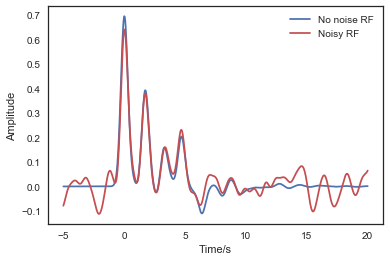

In [25]:
# calculate and plot receiver function
t,rfunc = rf.rfcalc(model)          # Receiver function
t2,rfunc2 = rf.rfcalc(model,sn=0.5) # Receiver function with added correlated noise
plt.plot(t,rfunc,label='No noise RF')
plt.plot(t2,rfunc2,'r-',label='Noisy RF')
plt.xlabel('Time/s')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

**Task 1:** Familiarise yourself with the function `rf.rfcalc()` and explore how the receiver function behaves as you change the model.

In [26]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



**Task 2:** Invent a model with around 5 layers, plot it and then compute the corresponding receiver function with the noise parameter $sn$ set to some reasonable value, say $sn=0.5$. Plot the noisy and noiseless receiver functions together just as in the figure above. We are going to treat the noisy receiver function as data.



In [27]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# generate new Earth model and plot it with receiver function


**Task 3:** To measure the fit of the observed and calculationed Receiver function we specify a Likelihood function $p({\mathbf d}_{obs}| {\mathbf m})$ 

\begin{equation*}
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
\end{equation*}

where ${\mathbf d}_{obs}$ is the observed receiver function and ${\mathbf d}_{pred}({\mathbf m})$ is the one predicted by model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given an Earth model.

In practice we usually need to evaluate the negative log of the Likelihood
which involves the inverse data covariance matrix describing correlated noise in the receiver function, $C_D^{-1}$ . For this problem you can evaluate $C_D^{-1}$ using the supplied routine InvDataCov($\sigma_t$,$\sigma_a$,$n$), which builds an $nxn$ inverse data covariance matrix for a time signal with amplitude variance $\sigma_a^2$ and time correlation length $\sigma_t$, for receiver length of $n$ time samples. In this example you can use $\sigma_t = 2.5$, $\sigma_a=0.01$. 

In this example we will also temper the Likelihood by rescaling the data covariance matrix by a temperature value, $T$, i.e. use $C_D^{-1}/T$ as the data covariance matrix in all calculations. This effectively reduces the size of `peakiness' of the posterior PDF to a simpler more manageable distribution. For this example set $T=100$.

Write a routine to compute the Likelihood of any test model using the above expression tempered by $T$.

In [28]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

Temp = 100 # Temperature
Cdinv = rf.InvDataCov(2.5,0.01,len(rfunc)) # 
Cdinv /= Temp # Temper Data covariance matrix



**Task 4:** Select two interface depth parameters in your model, i.e. 2 amd 3 would be a good pair. We will now pretend that the true depths of these two interfaces in the Earth model are 'unknown'. We will use McMC to try and sample the 2-D multi-modal PDF for these eparameters.

Choose a reasonable prior $p({\mathbf m})$ for this problem that you can generate samples from. A simple one might be uniform between fixed bounds. 

Suitable ranges for each variable would be $(0,60km)$ for an interface depth, $\pm 1.0 km/s$ for a $V_s$ variable and $\pm 0.5$ for $V_s/V_p$. 

Write a simple McMC sampler to determine the posterior distribution over these two parameters. 

You could do this by implementing the following simple algorithm:
- Step 0. Generate a  set of depths for your two interfaces ${\mathbf m} = (z_1,z_2)$ and calculate the Likelihood $L = p({\mathbf d}_{obs} | {\mathbf m}) $
- Step 1. Generate a new proposed model ${\mathbf m}^{\prime}$ as a random draw from the prior, and calculate its Likelihood, $L^{\prime}=p({\mathbf d}_{obs} | {\mathbf m}^{\prime}) $.
- Step 2. Generate $r$ as a random draw from $U[0,1]$. If $r < \frac{L^{\prime}}{L}$ set ${\mathbf m} = {\mathbf m}^{\prime}$.
- Step 3. Record ${\mathbf m}$ as an entry of your output ensemble and go to 1.

To do this you are advise to write routines to evaluate the Likelihood for a given model and data; and to draw a model from the prior.


To run your McMC sampler you will need to choose the length of the McMC chain, e.g. 100 for testing and at least $10^4$ for a reasonable run. Calculate and print out the percentage of accepted steps in the McMC chain. This number measured how efficient your chain is in drawing samples from the posterior PDF. It depends on the complexity of the target PDF. Ideally we would like values around 20%, but can live with > 5%. The lower it is the fewer useful samples you will have in the output chain and the more likely you will have to thin the output chain before calculating properties of your ensemble.

In [29]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



**Task 5:** Adjust your Markov chain until you are satsified that it has converged and use the output to select an ensemble of samples that you feel are reasonably distributed according to the posterior PDF for your two variables.
You may need to thin out the ensemble by subsampling. 

Plot the density of your McMC samples as a function of the two interface depths together with 1-D marginals for each interface. Compare these to a contour plot of the posterior distribution over the 2D model space.

In [30]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



In [31]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



**Task 6:** Calculate the MAP and mean models of the posterior ensemble.

In [32]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



**Task 7:** Calculate the posterior model covariance matrix and standard devistions of each depth parameter from this ensemble.

In [33]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 




**Task 8:** Plot the 68% and 95 Credible ellipses for this posterior model covariance matrix and compare to the density plot you obtained in task4.

In [34]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



Some further things to think about with your results
- What fraction of your proposed samples are accepted?
- How does the level of noise assumed in the Likelihood function impact results? You can test this by repeating with a different data covariance matrix. Can you explain the features that you observe?
- How many samples do you need to generate to get good results? Is your Markov chain stable (i.e., do two different portions of your chain share the same distribution)?